In [37]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('./../')  # Needed for importing from simulation_utils.py
from simulation_utils import *


### NumPy Sim


In [45]:

# Define BBPSSW circuit (Alice and Bob each apply CNOT: control=first qubit, target=second qubit)
bbpssw_circuit = QuantumCircuit([
    Gate(kron([I(), SWAP(), I()])),
    Gate(kron([CNOT(), CNOT()])),        # Apply CNOT(1A, 2A) and CNOT(1B, 2B)
    Gate(kron([I(), SWAP(), I()])),
])

# Construct POVM for the 2nd EPR pair (qubits 2A and 2B)
povm_epr2 = POVM(
    nqubits=4,
    meas_qubits=[2, 3],
    partial_trace=True,
)


In [47]:
numpy_sim_results = []

for epr_channel_fidelity in np.linspace(0, 1, 11):
    # Create two Werner states
    epr_1 = epr_2 = werner_state(epr_channel_fidelity)

    # Combined system: |1A, 1B, 2A, 2B⟩
    rho = kron([epr_1, epr_2])

    # Apply BBPSSW circuit
    rho = bbpssw_circuit(rho)

    # Measure qubits 2A and 2B
    probs, rho_outs = povm_epr2(rho)

    # Compute fidelity of surviving pair (1A-1B)
    target_state = bell_state(0, 0)
    fidels = np.array([fidelity(dm, target_state) for dm in rho_outs])

    # Compute success probability and fidelity
    prob_succ = probs[0] + probs[-1]
    fidel_succ = (fidels[0] * probs[0] + fidels[-1] * probs[-1]) / prob_succ if prob_succ else 0

    numpy_sim_results.append([epr_channel_fidelity, prob_succ, fidel_succ])

numpy_sim_results = pd.DataFrame(numpy_sim_results, columns=['EPR channel fidelity', 'P_Succ', 'F_succ'])

numpy_sim_results

,EPR channel fidelity,P_Succ,F_succ
0,0.0,0.500,0.250000
1,0.1,0.505,0.309406
2,0.2,0.520,0.384615
3,0.3,0.545,0.470183
4,0.4,0.580,0.560345
5,0.5,0.625,0.650000
6,0.6,0.680,0.735294
7,0.7,0.745,0.813758
8,0.8,0.820,0.884146
9,0.9,0.905,0.946133


### Extracting results from NetQASM

In [50]:
def _get_p_succ_and_f_succ(df: pd.DataFrame):
    """Computes the probability of success and fidelity given success."""
    return [
        1 - (df['M_Alice'] ^ df['M_Bob']).mean(),
        df.query('M_Alice == M_Bob')['Fidelity'].mean(),
    ]


def _series_to_numpy(s: pd.Series):
    """Converts a `pandas.Series` containing lists to a numpy array by depth-1 list flattening."""
    # NOTE: this function can only be applied to the specific series used here
    return np.array([np.concatenate(row) for row in s.items()])


def get_p_succ_and_f_succ(data: pd.DataFrame):
    """
    Computes the probability of success and fidelity given success,
    grouped by gate and EPR channel fidelities, in the given `DataFrame`.
    """
    # Group data by gate and channel fidelity
    result = data.groupby(['Gate fidelity', 'EPR channel fidelity'])

    result = result.apply(_get_p_succ_and_f_succ, include_groups=False)
    result = _series_to_numpy(result)

    cols = ['Gate fidelity', 'EPR channel fidelity', 'P_succ', 'F_succ']
    result = pd.DataFrame(result, columns=cols)

    return result

# Read simulation results
netqasm_sim_results = pd.read_csv('./out_bbpssw.csv')
netqasm_sim_results = get_p_succ_and_f_succ(netqasm_sim_results)

netqasm_sim_results

,Gate fidelity,EPR channel fidelity,P_succ,F_succ
0,0.0,1.0,0.51,0.215686
1,0.2,1.0,0.59,0.305085
2,0.4,1.0,0.63,0.444444
3,0.6,1.0,0.67,0.462687
4,0.8,1.0,0.87,0.712644


### Plotting

In [51]:
# Theoretical functions for BBPSSW
def prob_succ_theory(F: float):
    """Theoretical success probability for BBPSSW protocol"""
    return F**2 + (1-F)**2/9 + 2*F*(1-F)/3

def fidelity_succ_theory(F: float):
    """Theoretical fidelity after successful BBPSSW iteration"""
    numerator = F**2 + (1-F)**2/9
    denominator = F**2 + 2*F*(1-F)/3 + 5*(1-F)**2/9
    return numerator / denominator


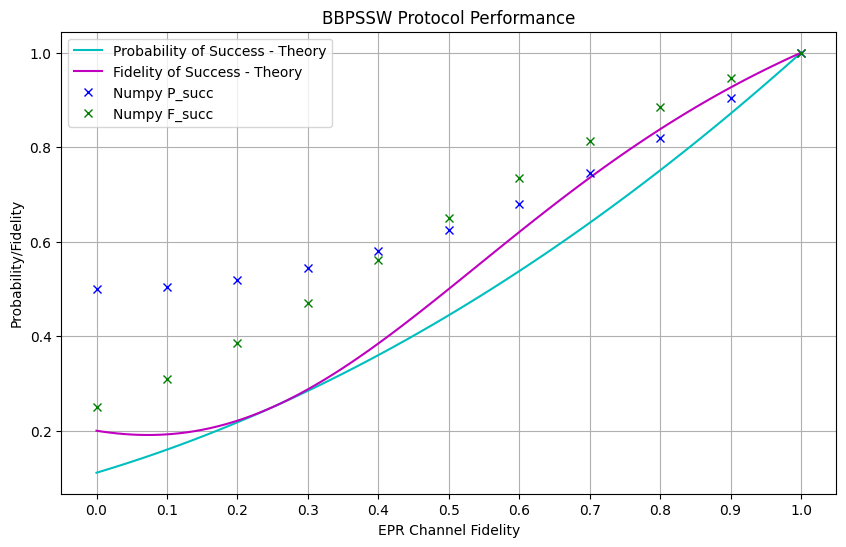

In [53]:

# Plotting code
ps = np.linspace(0, 1, 101)
plt.figure(figsize=(10, 6))

# Theory curves
plt.plot(ps, [prob_succ_theory(p) for p in ps], 'c-', label='Probability of Success - Theory')
plt.plot(ps, [fidelity_succ_theory(p) for p in ps], 'm-', label='Fidelity of Success - Theory')

# Numpy simulation results
plt.plot(numpy_sim_results['EPR channel fidelity'], numpy_sim_results['P_Succ'],
         'xb', label='Numpy P_succ')
plt.plot(numpy_sim_results['EPR channel fidelity'], numpy_sim_results['F_succ'],
         'xg', label='Numpy F_succ')

# Formatting
plt.title('BBPSSW Protocol Performance')
plt.xlabel('EPR Channel Fidelity')
plt.ylabel('Probability/Fidelity')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.grid(True)
plt.show()